                        Projet n°5 Catégorisez automatiquement des questions
Nous allons dans cette étude proposez une analyse textuelle des questions posées sur le site Stackoverflow. 
Notre objectif final est de suggérer des tags relatifs à la question posée afin d'aider les débutants dans leurs premiers pas sur le site.

Ce notebook représente le test des différents modèles
1. Importation des données
2. Approche non supervisée

2.1 Structure
2.2 Champs vides et dupliqués
2.3 Analyse univariée
2.4 Analyse multivariée
3. Réduction des Posts
3.1 Nettoyage du code dans le corps du post
3.2 Nettoyage des Posts
3.2.1 Initialisation
3.2.2 Traitement de l'ensemble du corpus
3.2.3 Nettoyage des textes et des Tags
3.3 Analyse textuelle
3.3.1 Représentation visuelle
3.3.2 Analyse de la distribution des tokens
3.3.3 Nettoyage aprés analyse
4. Sauvegarde du jeu de données nettoyé

In [17]:
# Bult-in
import os, sys, time, random

# Data
import numpy as np
import pandas as pd
from ast import literal_eval

# Visualizationraw_corpus
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
#from PIL import Image

import re

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import cluster, metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,\
                            recall_score, f1_score, jaccard_score

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import words

from pandarallel import pandarallel

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
sns.set()

/Applications/Anaconda/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Applications/Anaconda/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


# <a name="C1">1. Importation des données</a>

In [8]:
df = pd.read_csv("data/cleaned/df_final_version.csv",sep=';')

In [9]:
for col in ['Title', 'Body', 'Tags']:
     df[col] = df[col].apply(literal_eval)

In [10]:
df.head()

,Title,Body,Tags
0,"[selenium, button, webdriver, find]","[loosing, page, left, focus, href, working, cl...","[html, webdriver, selenium, python]"
1,"[policy, rest, access, nifi, api, using]","[policy, following, set, rest, instance, get, ...","[apache, rest, python]"
2,"[based, table, existence, subtable, row]","[fruit, table, select, enabled, seeing, fruits...","[mysql, sql]"
3,"[route, uris, go, localizing]","[register, go, multiple, route, french, versio...",[laravel]
4,"[service, public, app, access, restriction, az...","[image, networking, src, explorer, checked, fa...",[azure]


# <a name="C2">2. Approche non supervisée</a>

## <a name="C2.1">2.1 Latent Dirichlet Allocation</a>

### <a name="C2.1.1">2.1.1 Modèle de base</a>

In [11]:
# The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them :
# Dictionary
id2word = corpora.Dictionary(df.Body)
# Corpus
Texts = df.Body
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in Texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [18]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [19]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())

[(0,
  '0.060*"stack" + 0.057*"imgur" + 0.053*"png" + 0.051*"href" + 0.050*"rel" + '
  '0.049*"noreferrer" + 0.049*"nofollow" + 0.043*"src" + 0.042*"img" + '
  '0.042*"image"'),
 (1,
  '0.011*"run" + 0.011*"using" + 0.011*"file" + 0.009*"project" + '
  '0.008*"version" + 0.008*"server" + 0.008*"application" + 0.008*"get" + '
  '0.008*"build" + 0.007*"running"'),
 (2,
  '0.011*"question" + 0.009*"wa" + 0.009*"time" + 0.008*"know" + 0.008*"doe" + '
  '0.007*"way" + 0.007*"problem" + 0.006*"something" + 0.006*"find" + '
  '0.006*"even"'),
 (3,
  '0.040*"class" + 0.036*"pre" + 0.036*"lang" + 0.036*"override" + '
  '0.035*"prettyprint" + 0.020*"lt" + 0.016*"div" + 0.015*"true" + '
  '0.013*"false" + 0.012*"j"'),
 (4,
  '0.014*"animation" + 0.013*"weight" + 0.011*"obtain" + 0.011*"faster" + '
  '0.011*"vba" + 0.010*"letter" + 0.009*"middle" + 0.008*"scrolling" + '
  '0.008*"quote" + 0.008*"separated"'),
 (5,
  '0.013*"using" + 0.013*"app" + 0.011*"page" + 0.011*"user" + 0.011*"tried" + '
  '

In [21]:
#Print Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=Texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', round(coherence_lda,2))


Coherence Score:  0.5


In [24]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=Texts,
                                         dictionary=id2word, 
                                         coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [25]:
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
topics_range = range(2, 20, 2)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
    pbar.close()


  0%|                                                   | 0/540 [29:57<?, ?it/s]

  6%|██▎                                | 35/540 [10:47:11<44:37:04, 318.07s/it]

KeyboardInterrupt: 

In [39]:
num_topics = 8

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

Nb_topics : 3, Coherence Score : 0.45528558396442104
Nb_topics : 4, Coherence Score : 0.5078678025780694
Nb_topics : 5, Coherence Score : 0.5004623049188166
Nb_topics : 6, Coherence Score : 0.4753899003932973
Nb_topics : 7, Coherence Score : 0.474959786747556
Nb_topics : 8, Coherence Score : 0.4786610618168548
Nb_topics : 9, Coherence Score : 0.4921675071118009
Nb_topics : 10, Coherence Score : 0.47603597127137165
Nb_topics : 11, Coherence Score : 0.4517544887652524
Nb_topics : 12, Coherence Score : 0.4731373000541159
Nb_topics : 13, Coherence Score : 0.5032193101681075
Nb_topics : 14, Coherence Score : 0.46135328781091994
Nb_topics : 15, Coherence Score : 0.45587558099360065
Nb_topics : 16, Coherence Score : 0.5152972270713547
Nb_topics : 17, Coherence Score : 0.4664432548733696
Nb_topics : 18, Coherence Score : 0.48570045721774474
Nb_topics : 19, Coherence Score : 0.47044513124105647
Nb_topics : 20, Coherence Score : 0.48650259663046597
Nb_topics : 21, Coherence Score : 0.46474098920

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Applications/Anaconda/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Applications/Anaconda/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Applications/Anaconda/anaconda3/lib/python3.9/site-packages/gensim/__init__.py", line 11, in <module>
    from gensim import parsing, corpora, matutils, interfaces, models, similarities, utils  # noqa:F401
  File "/Applications/Anaconda/anaconda3/lib/python3.9/site-packages/gensim/corpora/__init__.py", line 6, in <module>
    from .indexedcorpus import IndexedCorpus  # noqa:F401 must appear before the other classes
  File "/Applications/Anaconda/anaconda3/lib/python3.9/site-packages/gensim/corpora/indexedcorpus.py", line 14, in <module>
    from gensim import interfaces, utils
  File "/Applications/Anaconda/anacond

KeyboardInterrupt: 

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

# <a name="C3">3. Approche supervisée</a>

In [46]:
df

,Title,Body,Tags
0,"[selenium, button, webdriver, find]","[loosing, page, left, focus, href, working, cl...","[html, webdriver, selenium, python]"
1,"[policy, rest, access, nifi, api, using]","[policy, following, set, rest, instance, get, ...","[apache, rest, python]"
2,"[based, table, existence, subtable, row]","[fruit, table, select, enabled, seeing, fruits...","[mysql, sql]"
3,"[route, uris, go, localizing]","[register, go, multiple, route, french, versio...",[laravel]
4,"[service, public, app, access, restriction, az...","[image, networking, src, explorer, checked, fa...",[azure]
...,...,...,...
78446,"[phone, device, near, bluetooth, detect, scann...","[part, enabled, even, alright, video, message,...","[java, android]"
78447,"[missing_enum_constant_in_switch, make, dart, ...","[github, image, severity, src, complete, langu...","[flutter, dart]"
78448,"[default, cplex, option]","[something, faster, native, ol, problem, linea...",[python]
78449,"[term, many, efficiently, filter]","[elsewhere, command, expect, something, questi...","[r, data, dataframe]"


In [5]:
%%time
# Define X and y
X = df["Body"]
y = df["Tags"]

# Initialize the "CountVectorizer" TFIDF for the Body
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.97,
                             min_df= 3,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)
vectorizer.fit(X)
X_tfidf = vectorizer.transform(X)

print(X_tfidf.shape)

# Multilabel binarizer for targets
mlb = MultiLabelBinarizer()
mlb.fit(y)
y_mlb = mlb.transform(y)

print(y_mlb.shape)

(78451, 26530)
(78451, 100)
CPU times: user 5.97 s, sys: 184 ms, total: 6.15 s
Wall time: 6.18 s


In [6]:
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_mlb,
                                                    test_size=0.3, random_state=42)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (54915, 26530)
X_test shape : (23536, 26530)
y_train shape : (54915, 100)
y_test shape : (23536, 100)


In [7]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#ARI = np.round(metrics.adjusted_rand_score(y_pred, clf.labels_),4)
        

/Applications/Anaconda/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [9]:
print("Accuracy : ", accuracy_score(y_test, y_pred))
print("Precision : ", precision_score(y_test, y_pred, average='samples'))
print("Recall : ", recall_score(y_test, y_pred, average='samples')) 
print("F1 Score : ", f1_score(y_test, y_pred, average='samples'))
print("Jaccard :", jaccard_score(y_test, y_pred, average='samples'))

Accuracy :  0.16374915023793338


/Applications/Anaconda/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision :  0.39852313376064225
Recall :  0.307191870204914
F1 Score :  0.3276766017142462
Jaccard : 0.285180354947945


In [16]:
%%time
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

svm_clf = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

CPU times: user 1.1 s, sys: 275 ms, total: 1.38 s
Wall time: 21.5 s


In [17]:
print("Accuracy : ", accuracy_score(y_test, y_pred))
print("Precision : ", precision_score(y_test, y_pred, average='samples'))
print("Recall : ", recall_score(y_test, y_pred, average='samples')) 
print("F1 Score : ", f1_score(y_test, y_pred, average='samples'))
print("Jaccard :", jaccard_score(y_test, y_pred, average='samples'))

Accuracy :  0.24405166553365057


/Applications/Anaconda/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision :  0.5710415250396556
Recall :  0.4731863649606681
F1 Score :  0.48934505449418775
Jaccard : 0.4279846037950643


In [18]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

In [19]:
print("Accuracy : ", accuracy_score(y_test, y_pred))
print("Precision : ", precision_score(y_test, y_pred, average='samples'))
print("Recall : ", recall_score(y_test, y_pred, average='samples')) 
print("F1 Score : ", f1_score(y_test, y_pred, average='samples'))
print("Jaccard :", jaccard_score(y_test, y_pred, average='samples'))

Accuracy :  0.09882732834806254


/Applications/Anaconda/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision :  0.24290802741898934
Recall :  0.1650056853128743
F1 Score :  0.1862661926882695
Jaccard : 0.1624879617040562


In [25]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = OneVsRestClassifier(GradientBoostingClassifier())
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)

KeyboardInterrupt: 

In [23]:
print("Accuracy : ", accuracy_score(y_test, y_pred))
print("Precision : ", precision_score(y_test, y_pred, average='samples'))
print("Recall : ", recall_score(y_test, y_pred, average='samples')) 
print("F1 Score : ", f1_score(y_test, y_pred, average='samples'))
print("Jaccard :", jaccard_score(y_test, y_pred, average='samples'))

Accuracy :  0.09882732834806254


/Applications/Anaconda/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision :  0.24290802741898934
Recall :  0.1650056853128743
F1 Score :  0.1862661926882695
Jaccard : 0.1624879617040562


# Word2Vec

In [17]:
df.Post = df.Title + df.Body
corpus = df.Post.tolist()
print (corpus[0])

['selenium', 'button', 'webdriver', 'find', 'loosing', 'page', 'left', 'focus', 'href', 'working', 'click', 'next', 'go', 'open', 'html', 'class_name', 'really', 'button', 'job', 'rel', 'switch', 'application', 'hung', 'break', 'throwing', 'element', 'right', 'post', 'bot', 'apply', 'www', 'iframe', 'noreferrer', 'tag_name', 'try', 'pane', 'indeed', 'nofollow', 'css_selector', 'xpath', 'nothing', 'find', 'used', 'finding']


/var/folders/dz/v9mhgdhn03n30_kgvk_0mcfc0000gn/T/ipykernel_6831/2278853074.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Post = df.Title + df.Body


In [18]:
document = [" ".join(doc) for doc in corpus]
print (document[0])

selenium button webdriver find loosing page left focus href working click next go open html class_name really button job rel switch application hung break throwing element right post bot apply www iframe noreferrer tag_name try pane indeed nofollow css_selector xpath nothing find used finding


In [20]:
# Vectorisation
from gensim.models import Word2Vec
model = Word2Vec(df.Body, vector_size=2, window=5)

In [22]:
# Type de l'objet
print (type(model))

<class 'gensim.models.word2vec.Word2Vec'>


In [23]:
# Propriété de l'objet
dir(model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_check_corpus_sanity',
 '_check_training_sanity',
 '_clear_post_train',
 '_do_train_epoch',
 '_do_train_job',
 '_get_next_alpha',
 '_get_thread_working_mem',
 '_job_producer',
 '_load_specials',
 '_log_epoch_end',
 '_log_epoch_progress',
 '_log_progress',
 '_log_train_end',
 '_raw_word_count',
 '_save_specials',
 '_scan_vocab',
 '_smart_save',
 '_train_epoch',
 '_train_epoch_corpusfile',
 '_worker_loop',
 '_worker_loop_corpusfile',
 'add_lifecycle_event',
 'add_null_word',
 'alpha',
 'batch_words',
 'build_vocab',
 'build_vocab_from_freq',
 'cbow_mean',
 'comment',
 'compute_loss',
 'corpus_count',
 

In [24]:
words = model.wv
print (type(words))

<class 'gensim.models.keyedvectors.KeyedVectors'>


In [25]:
dir(words)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_load_specials',
 '_log_evaluate_word_analogies',
 '_save_specials',
 '_smart_save',
 '_upconvert_old_d2vkv',
 '_upconvert_old_vocab',
 'add_lifecycle_event',
 'add_vector',
 'add_vectors',
 'allocate_vecattrs',
 'closer_than',
 'cosine_similarities',
 'distance',
 'distances',
 'doesnt_match',
 'evaluate_word_analogies',
 'evaluate_word_pairs',
 'expandos',
 'fill_norms',
 'get_index',
 'get_normed_vectors',
 'get_vecattr',
 'get_vector',
 'has_index_for',
 'index2entity',
 'index2word',
 'index_to_key',
 'init_sims',
 'intersect_word2vec_

In [26]:
# affichage des termes et leur index
words.key_to_index

{'using': 0,
 'href': 1,
 'like': 2,
 'get': 3,
 'tried': 4,
 'rel': 5,
 'noreferrer': 6,
 'nofollow': 7,
 'trying': 8,
 'file': 9,
 'data': 10,
 'class': 11,
 'stack': 12,
 'way': 13,
 'imgur': 14,
 'problem': 15,
 'following': 16,
 'png': 17,
 'function': 18,
 'image': 19,
 'ha': 20,
 'src': 21,
 'example': 22,
 'know': 23,
 'new': 24,
 'wa': 25,
 'run': 26,
 'doe': 27,
 'img': 28,
 'make': 29,
 'alt': 30,
 'however': 31,
 'time': 32,
 'strong': 33,
 'pre': 34,
 'working': 35,
 'lang': 36,
 'override': 37,
 'user': 38,
 'app': 39,
 'prettyprint': 40,
 'see': 41,
 'first': 42,
 'find': 43,
 'enter': 44,
 'try': 45,
 'description': 46,
 'return': 47,
 'set': 48,
 'add': 49,
 'name': 50,
 'change': 51,
 'result': 52,
 'j': 53,
 'type': 54,
 'something': 55,
 'lt': 56,
 'getting': 57,
 'question': 58,
 'project': 59,
 'used': 60,
 'method': 61,
 'look': 62,
 'thanks': 63,
 'output': 64,
 'two': 65,
 'able': 66,
 'show': 67,
 'html': 68,
 'please': 69,
 'list': 70,
 'table': 71,
 'without

In [28]:
words.vectors.shape

(18615, 2)

In [31]:
# ex coordonnées de Pyhton
vec1 = words['python']
vec1

array([1.1417198, 2.7955673], dtype=float32)

In [32]:
vec2 = words['message']
vec2

array([2.7660348, 9.480032 ], dtype=float32)

In [33]:
# similarité entre les 2 mots
print (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*(np.linalg.norm(vec2))))

0.9946139


In [34]:
# similarité de gensim
words.similarity('python', 'message')

0.9946139

In [35]:
# les termes les plus proches de 'python'
words.most_similar('python')

[('four', 1.0),
 ('misunderstanding', 1.0),
 ('pearson', 1.0),
 ('no_grad', 1.0),
 ('axios', 1.0),
 ('chown', 1.0),
 ('versus', 1.0),
 ('datastore', 1.0),
 ('internals', 0.9999999403953552),
 ('sticky', 0.9999998807907104)]

In [36]:
dfw = pd.DataFrame(words.vectors, columns=['V1','V2'], index=words.key_to_index.keys())
print (dfw)

                   V1         V2
using        1.823726  -6.357977
href         3.535530  11.786755
like         2.638096 -10.173257
get          2.465235   8.471773
tried        3.254647 -12.859330
...               ...        ...
miller       0.769757   0.258340
stevens      1.081672  -0.268939
operationid -0.113805   0.331157
setstring    0.223616  -0.076628
maxscale     0.384248  -0.268416

[18615 rows x 2 columns]


In [37]:
# qq mots clés
mots =['python', 'javascript', 'datastore', 'string']
dfMots = dfw.loc[mots,:]

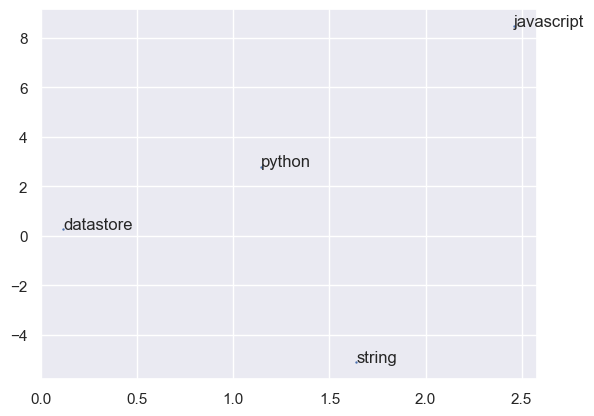

In [38]:
# représentation graphique 
plt.scatter(dfMots.V1, dfMots.V2, s=0.5)
for i in range(dfMots.shape[0]):
    plt.annotate(dfMots.index[i], (dfMots.V1[i], dfMots.V2[i]))
plt.show()
    